In [1]:
from importlib import reload
import platform, os, sys, datetime, re, itertools
from os.path import join
from glob import glob
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# sys.path.append(join(root_dir,'cvtracer'))
import cvt
from cvt.TrAQ.Trial import Trial
from cvt.TrAQ.Tank import Tank
# from cvt.TrAQ.CVTracer import CVTracer, create_named_window, wait_on_named_window

In [2]:
reload(cvt.TrAQ.Trial)
from cvt.TrAQ.Trial import Trial
reload(cvt.TrAQ.Tank)
from cvt.TrAQ.Tank import Tank

# Load a trial

In [3]:
# trial_files = sorted(glob('../tracking/full/*/trial.pik'))
trial_files = sorted(glob('./test/output/*/trial.pik'))
display(trial_files)

trial = Trial()
trial.load(trial_files[0])
display(trial.df[:3])
# trial.df.to_excel(trial.output_dir+'/df.xlsx')

['./test/output/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000_60-70/trial.pik']


        Trial loaded from ./test/output/Pa_Fri_7dpf_GroupA_n5_2020-06-05-083453-0000_60-70/trial.pik 


0                                       1              \
              x_px        y_px       ang  area        x_px        y_px   
frame                                                                    
1      1225.784512  964.097643 -0.269401  49.5  659.601246  826.557632   
2      1229.255892  962.245791 -0.360581  49.5  659.678788  826.712121   
3      1231.894231  961.336538 -0.348254  52.0  659.600601  826.537538   

                                 2                                        3  \
            ang  area         x_px        y_px       ang  area         x_px   
frame                                                                         
1      1.133934  53.5  1053.948012  740.568807  1.419361  54.5  1173.619529   
2      1.130506  55.0  1053.934579  740.819315  1.451906  53.5  1173.250000   
3      1.105541  55.5  1054.009091  740.709091  1.435091  55.0  1173.255452   

                                            4                              
             y_px       ang  area        x_px        y_px       ang  area  
frame                                                                      
1      633.272727 -0.105694  49.5  613.112319  591.010870  1.033016  46.0  
2      633.250000 -0.075710  50.0  613.275986  591.437276  1.008969  46.5  
3      633.133956 -0.079897  53.5  612.904762  591.027778  0.996083  42.0

# Compute spatial and kinematic quantities

In [4]:
trial.convert_pixels_to_cm()

fish = trial.df.columns.levels[0]

for f in fish:
    
    trial.df[f,'d_wall'] = trial.tank.r_cm - np.hypot(trial.df[f,'x'],trial.df[f,'y'])
    
    trial.df[f,'v_x']    = trial.df[f,'x'].diff()*trial.fps
    trial.df[f,'v_y']    = trial.df[f,'y'].diff()*trial.fps
    trial.df[f,'v']      = np.hypot(trial.df[f,'v_x'],trial.df[f,'v_y'])
    
    ang_diff             = trial.df[f,'ang'].diff()
    ang_diff            -= 2*np.pi*np.rint(ang_diff/(2*np.pi))
    trial.df[f,'v_ang']  = ang_diff*trial.fps
    
# Reorder columns.
# trial.df = trial.df.sort_index(axis=1) # Sort alphabetically, which also sorts by fish.
columns = [ (f,q) for f in fish for q in ['x_px', 'y_px', 'area', 'ang', 'v_ang', 
                                          'x', 'y', 'v_x', 'v_y', 'v', 'd_wall'] ]
trial.df = trial.df.reindex(columns=columns)
display(trial.df[:3])

0                                                            \
              x_px        y_px  area       ang     v_ang         x         y   
frame                                                                          
1      1225.784512  964.097643  49.5 -0.269401       NaN  2.335802 -3.866045   
2      1229.255892  962.245791  49.5 -0.360581 -2.735399  2.375051 -3.845108   
3      1231.894231  961.336538  52.0 -0.348254  0.369820  2.404881 -3.834827   

                                     ...           4                  \
            v_x       v_y         v  ...        y_px  area       ang   
frame                                ...                               
1           NaN       NaN       NaN  ...  591.010870  46.0  1.033016   
2      1.177466  0.628134  1.334533  ...  591.437276  46.5  1.008969   
3      0.894904  0.308412  0.946558  ...  591.027778  42.0  0.996083   

                                                                             
          v_ang         x         y       v_x       v_y         v    d_wall  
frame                                                                        
1           NaN -4.591322  0.352227       NaN       NaN       NaN  0.195187  
2     -0.721426 -4.589472  0.347406  0.055515 -0.144634  0.154922  0.197398  
3     -0.386592 -4.593669  0.352036 -0.125916  0.138899  0.187477  0.192862  

[3 rows x 55 columns]

# Perform cuts

{'d_wall': 1.0,
 'v': 0.9906976744186047,
 'v_ang': 0.9966777408637874,
 'final': 0.9906976744186047}

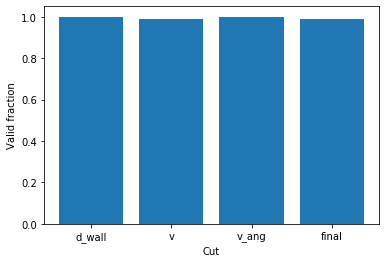

0                                                              \
            ang     v_ang         x         y       v_x       v_y         v   
frame                                                                         
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN   
2     -0.360581 -2.735399  2.375051 -3.845108  1.177466  0.628134  1.334533   
3     -0.348254  0.369820  2.404881 -3.834827  0.894904  0.308412  0.946558   

                        1            ...         3                   4  \
         d_wall       ang     v_ang  ...         v    d_wall       ang   
frame                                ...                                 
1           NaN       NaN       NaN  ...       NaN       NaN       NaN   
2      0.280518  1.130506 -0.102818  ...  0.125578  3.053671  1.008969   
3      0.273483  1.105541 -0.748961  ...  0.039405  3.053703  0.996083   

                                                                             
          v_ang         x         y       v_x       v_y         v    d_wall  
frame                                                                        
1           NaN       NaN       NaN       NaN       NaN       NaN       NaN  
2     -0.721426 -4.589472  0.347406  0.055515 -0.144634  0.154922  0.197398  
3     -0.386592 -4.593669  0.352036 -0.125916  0.138899  0.187477  0.192862  

[3 rows x 40 columns]

In [5]:
cut_ranges = { 'd_wall': [0,trial.tank.r_cm], 
               'v':      [0,np.inf], 
               'v_ang':  [-np.inf,np.inf] }


# Locate fish/frame combinations that didn't make the cut(s).
cut_names = [ 'cut_'+q for q in cut_ranges.keys() ]
valid_fraction = {}
for f in fish:
    for q,(vmin,vmax) in cut_ranges.items():
        trial.df[f,'cut_'+q]  = (trial.df[f,q]>vmin) & (trial.df[f,q]<vmax)
    trial.df[f,'cut_final'] = trial.df.loc[:,(f,cut_names)].all(axis=1)

    
# # For each fish, compute the fraction of points that made it through each cut.
# valid_fraction = {}
# for f in fish:
#     for c in list(cut_ranges.keys())+['final']:
#         valid_fraction[f,c] = trial.df[f,'cut_'+c].mean()
# display(valid_fraction)

# Compute the fraction of points that made it through each cut.
valid_fraction = {}
for c in list(cut_ranges.keys())+['final']:
    B = [trial.df[f,'cut_'+c] for f in fish]
    valid_fraction[c] = sum([b.sum() for b in B])/sum([len(b) for b in B])
display(valid_fraction)

# Plot the fraction of points that made it through each cut.
plt.bar(*zip(*valid_fraction.items()))
plt.xlabel('Cut')
plt.ylabel('Valid fraction')
plt.show()


# Reorder columns.
columns = [ (f,q) for f in fish for q in ['x_px', 'y_px', 'area', 
                                          'ang', 'v_ang', 'cut_v_ang', 
                                          'x', 'y', 'v_x', 'v_y', 'v', 'cut_v', 
                                          'd_wall', 'cut_d_wall', 
                                          'cut_final'] ]
trial.df = trial.df.reindex(columns=columns)
# display(trial.df[0][:3])


# Create a filtered dataframe.
cols = ['ang', 'v_ang', 'x', 'y', 'v_x', 'v_y', 'v', 'd_wall']
df = trial.df.loc[:,(slice(None),cols)].copy()
for f in fish:
    df.loc[~trial.df[f,'cut_final'],f] = np.nan
display(df[:3])    

# Compute and plot distributions

TODO: Compute histogram for each fish, then use the standard error as the uncertainty on the distribution.

### Distance to the wall

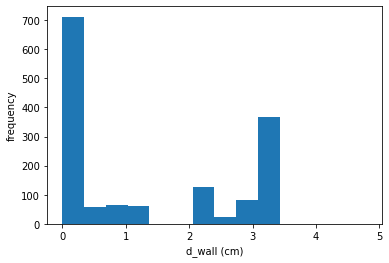

In [6]:
quantity = 'd_wall'
unit = 'cm'
bins = np.linspace(0,trial.tank.r_cm,15)

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.show()

### Velocity

/home/yaouen/software/miniconda3/envs/cvtracer/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/home/yaouen/software/miniconda3/envs/cvtracer/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


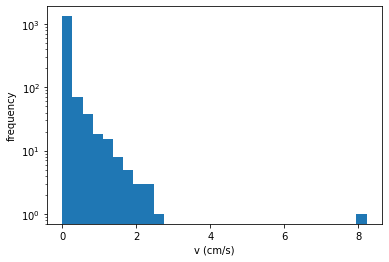

In [7]:
quantity = 'v'
unit = 'cm/s'
bins = 30

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

In [8]:
# fast = trial.df.loc[:,(slice(None),'v')]>6
# print(np.nonzero(fast.values))
# display(trial.df.iloc[266:269][4])

### Angular velocity

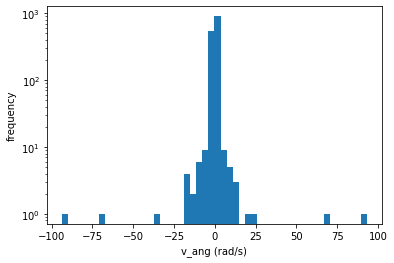

In [9]:
quantity = 'v_ang'
unit = 'rad/s'
bins = 50

values = df.loc[:,(slice(None),quantity)].values.flatten()
plt.hist(values,bins=bins)
plt.xlabel(f'{quantity} ({unit})')
plt.ylabel('frequency')
plt.yscale('log')
plt.show()

In [10]:
# At 30 fps, |v_ang|=30 (about where the rare peaks start) 
# corresponds to about pi/3 in one frame.
print('v_ang for pi/3 in (1/30) second:',np.pi/3*trial.fps)

print('Instances of unusually high v_ang:')
for f in fish:
    ang_diff  = trial.df[f,'ang'].diff()
    ang_diff -= 2*np.pi*np.rint(ang_diff/(2*np.pi))
    I = np.nonzero(np.absolute(ang_diff.values)>1)[0]
    for i in I:
        display(trial.df[f,'ang'][i-1:i+2])

v_ang for pi/3 in (1/30) second: 31.415926535897928
Instances of unusually high v_ang:


/home/yaouen/software/miniconda3/envs/cvtracer/lib/python3.7/site-packages/ipykernel_launcher.py:9: RuntimeWarning: invalid value encountered in greater
  if __name__ == '__main__':


frame
208   -2.651258
209   -3.781640
210   -3.747212
Name: (0, ang), dtype: float64

frame
40   -0.126642
41    3.038630
42    3.086760
Name: (3, ang), dtype: float64

frame
134    1.211825
135    4.312780
136    4.280874
Name: (4, ang), dtype: float64

frame
266     5.603216
267     7.938640
268    11.913747
Name: (4, ang), dtype: float64

frame
267     7.938640
268    11.913747
269    11.711038
Name: (4, ang), dtype: float64

### Pair distance-pair angle distribution

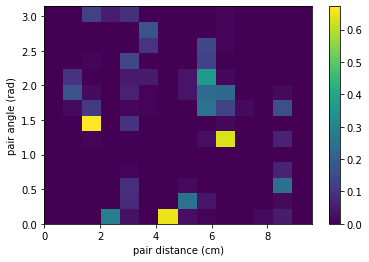

In [11]:
bins_d = np.linspace(0,2*trial.tank.r_cm,15)
bins_a = np.linspace(0,np.pi,15)
H      = [] # np.zeros((len(bins_d)-1,len(bins_a)-1))
for f1,f2 in itertools.combinations(fish,2):
#     print(f1,f2)
    d = np.hypot(df[f1,'x']-df[f2,'x'],df[f1,'y']-df[f2,'y'])
    a = df[f1,'ang']-df[f2,'ang']
    a = a - 2*np.pi*np.rint(a/(2*np.pi))
    
    h,_,_ = np.histogram2d(d,a,bins=(bins_d,bins_a),normed=True)
    H.append(h)

H   = np.mean(H,axis=0)
plt.pcolormesh(bins_d,bins_a,H.T)
plt.xlabel('pair distance (cm)')
plt.ylabel('pair angle (rad)')
plt.colorbar()
plt.show()

# Angular dynamics

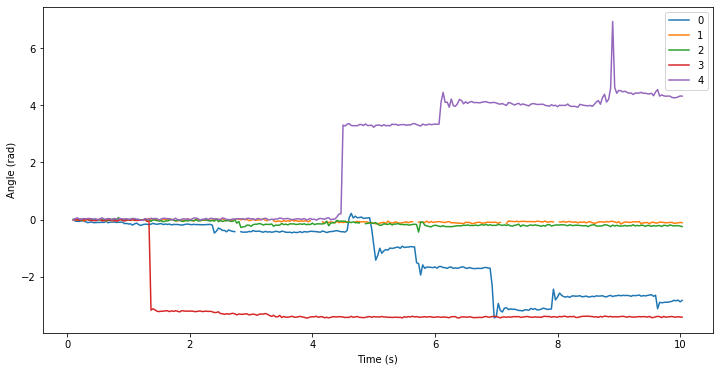

In [12]:
# %matplotlib notebook
# %matplotlib notebook
# %matplotlib inline

plt.figure(figsize=(12,6))
for f in fish:
    t    = df.index/trial.fps
    ang  = df[f,'ang']

    dang = ang.diff()
    dang = dang - 2*np.pi*np.rint(dang/(2*np.pi))
    ang  = np.cumsum(dang)

    I = (t>297) & (t<301)
    # t,th = t[I],th[I]

    # plt.figure(figsize=(12,6))
    # plt.xlim(297,301)
    plt.plot(t,ang,label=f) #,marker='.')

plt.xlabel('Time (s)')
plt.ylabel('Angle (rad)')
# plt.savefig(trial.make_fig_file('angle-vs-time',''),**trial.plot_options)
plt.legend()
plt.show()